# Modelo de Hodgkin y Huxley

# Cálculo de Curvas f-I

Este notebook tiene como objetivo calcular las curvas $ f-I $ (frecuencia-corriente), así como aprender a hacer análisis de tiempos de disparo.

### Ejercicio 1:

Construir la curva f-I del modelo de HH con los parámetros dados en la clase anterior. A qué tipo de clase de excitabilidad corresponde el modelo de HH con los parámetros estudiados?

/tmp/ipython-input-891662262.py:45: RuntimeWarning: overflow encountered in exp
  return (0.1*(V+40))/(1-np.exp(-(V+40)/10))
/tmp/ipython-input-891662262.py:48: RuntimeWarning: overflow encountered in exp
  return 4*np.exp(-(V+65)/18)
/tmp/ipython-input-891662262.py:39: RuntimeWarning: overflow encountered in exp
  return (0.01*(V+55))/(1-np.exp(-(V+55)/10))
/tmp/ipython-input-891662262.py:42: RuntimeWarning: overflow encountered in exp
  return 0.125*np.exp(-(V+65)/80)
/tmp/ipython-input-891662262.py:51: RuntimeWarning: overflow encountered in exp
  return 0.07*np.exp(-(V+65)/20)
/tmp/ipython-input-891662262.py:54: RuntimeWarning: overflow encountered in exp
  return (1)/(1+np.exp(-(V+35)/10))


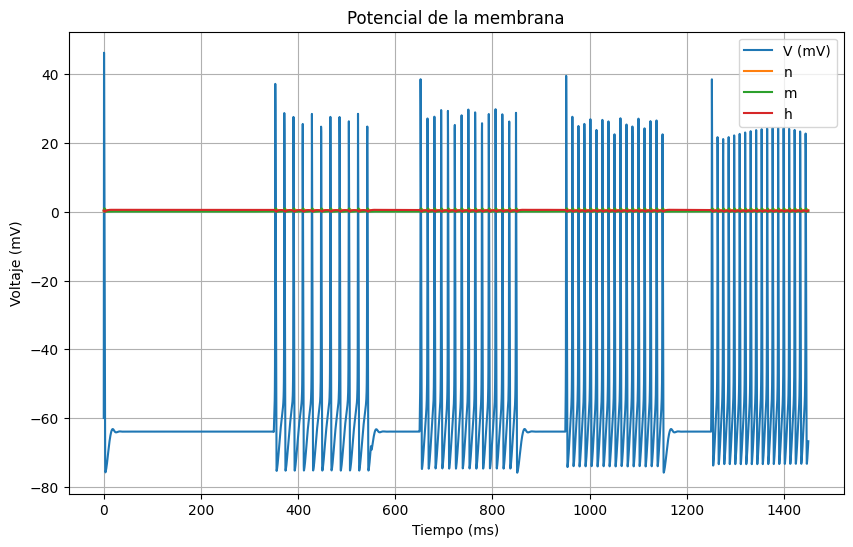

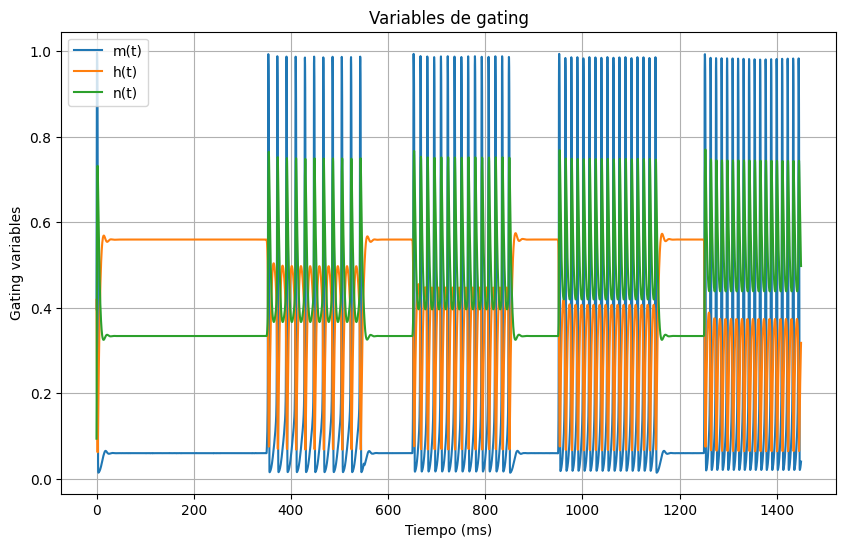

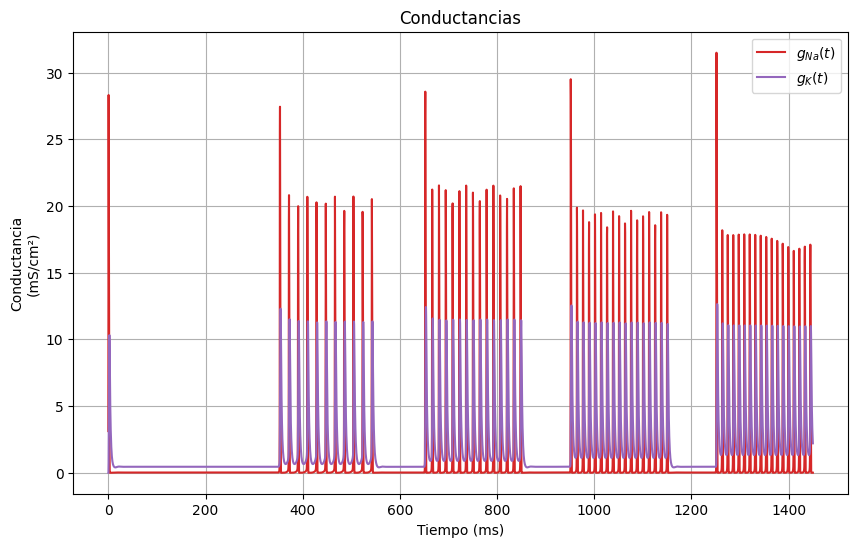

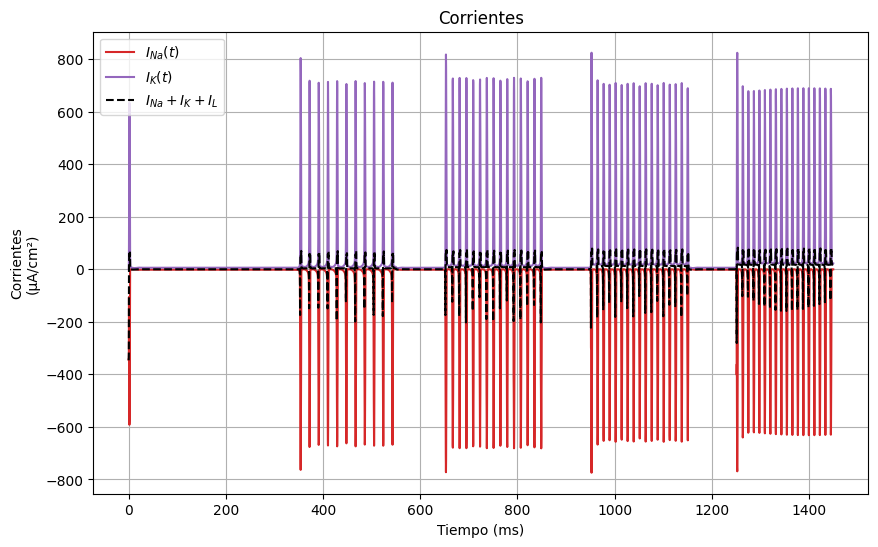

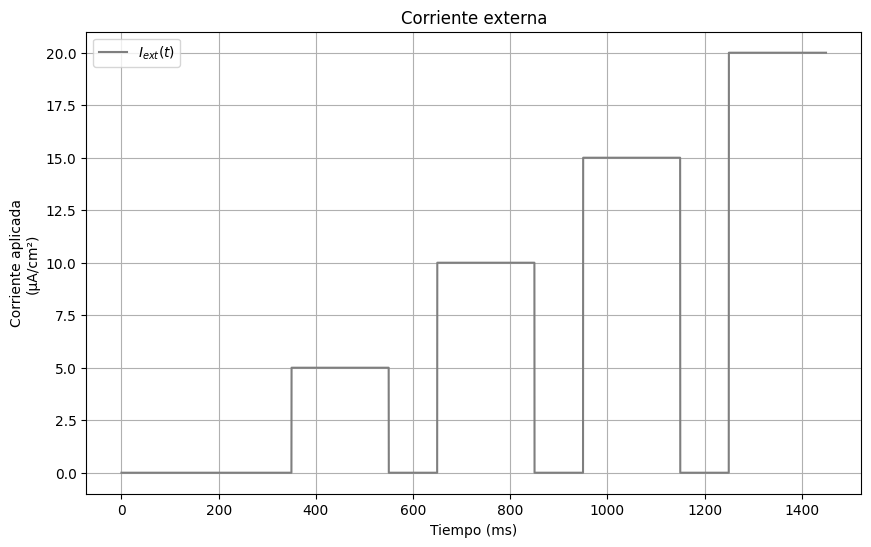

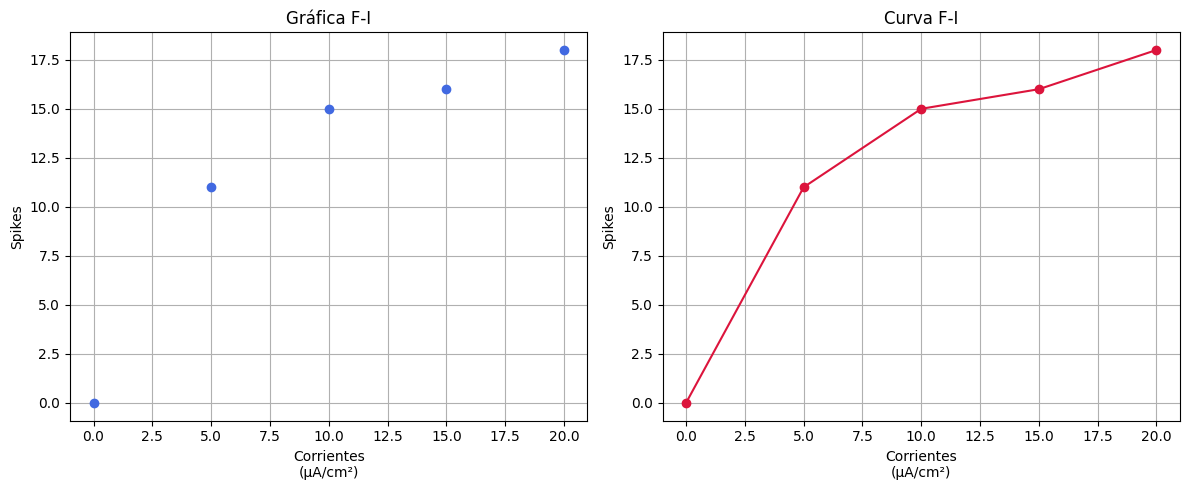

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import find_peaks

# --- Parámetros del modelo ---
Cm = 1      # Capacitancia de membrana (μF/cm^2)
gNa = 120   # Conductancia máxima del canal de sodio (mS/cm^2)
gK = 36     # Conductancia máxima del canal de potasio (mS/cm^2)
gL = 0.3    # Conductancia de fuga (mS/cm^2)

ENa = 50    # Potencial de equilibrio del sodio (mV)
Ek = -77    # Potencial de equilibrio del potasio (mV)
EL = -50    # Potencial de equilibrio de fuga (mV)

inicio_pulsos = [50, 350, 650, 950, 1250]   # inicio de cada pulso (ms)
amplitud_pulso = [0, 5, 10, 15, 20]         # amplitud de corriente (μA/cm²)
duracion_pulso = 200                        # duración de cada pulso (ms)
tiempo_simulacion = 1450

# --- Funciones de transición de compuertas ---
'''
def alpha_n(V): return (0.01 * (V + 55)) / (1 - np.exp(-(V + 55) / 10))
def beta_n(V):  return 0.125 * np.exp(-(V + 65) / 80)
def alpha_m(V): return (0.1 * (V + 40)) / (1 - np.exp(-(V + 40) / 10))
def beta_m(V):  return 4 * np.exp(-(V + 65) / 18)
def alpha_h(V): return 0.07 * np.exp(-(V + 65) / 20)
def beta_h(V):  return 1 / (1 + np.exp(-(V + 35) / 10))

def n_inf(V): return alpha_n(V) / (alpha_n(V) + beta_n(V))
def m_inf(V): return alpha_m(V) / (alpha_m(V) + beta_m(V))
def h_inf(V): return alpha_h(V) / (alpha_h(V) + beta_h(V))

def tau_n(V): return 1 / (alpha_n(V) + beta_n(V))
def tau_m(V): return 1 / (alpha_m(V) + beta_m(V))
def tau_h(V): return 1 / (alpha_h(V) + beta_h(V))
'''
def alpha_n(V):
  return (0.01*(V+55))/(1-np.exp(-(V+55)/10))

def beta_n(V):
  return 0.125*np.exp(-(V+65)/80)

def alpha_m(V):
  return (0.1*(V+40))/(1-np.exp(-(V+40)/10))

def beta_m(V):
  return 4*np.exp(-(V+65)/18)

def alpha_h(V):
  return 0.07*np.exp(-(V+65)/20)

def beta_h(V):
  return (1)/(1+np.exp(-(V+35)/10))

# --- Corriente externa aplicada ---
def I_ext_func(t):
     for inicio, amp in zip(inicio_pulsos, amplitud_pulso):
        if inicio <= t <= inicio + duracion_pulso:
            return amp
     return 0.0

# --- Ecuaciones diferenciales del modelo ---
def hodgkin_huxley(t, y):
    V, n, m, h = y

    # Corrientes iónicas
    INa = gNa * (m**3) * h * (V - ENa)
    IK = gK * (n**4) * (V - Ek)
    IL = gL * (V - EL)

    # Derivadas
    I = I_ext_func(t)    # Corriente externa en cada pulso
    '''
    dVdt = (I - INa - IK - IL) / Cm
    dndt = (n_inf(V) - n) / tau_n(V)
    dmdt = (m_inf(V) - m) / tau_m(V)
    dhdt = (h_inf(V) - h) / tau_h(V)
    '''

    dVdt = (I - (INa+IK+IL))/(Cm)
    dmdt = alpha_m(V)*(1-m) - beta_m(V)*m
    dndt = alpha_n(V)*(1-n) - beta_n(V)*n
    dhdt = alpha_h(V)*(1-h) - beta_h(V)*h

    return [dVdt, dndt, dmdt, dhdt]

# --- Condiciones iniciales ---
V0 = -60  # mV
m_0 = (alpha_m(V0))/(alpha_m(V0)+beta_m(V0))
n_0 = (alpha_n(V0))/(alpha_n(V0)+beta_n(V0))
h_0 = (alpha_h(V0))/(alpha_h(V0)+beta_h(V0))

# X0 = [V0,m_0,n_0,h_0]
# y0 = [V0, n_inf(V0), m_inf(V0), h_inf(V0)]
y0 = [V0,m_0,n_0,h_0]

# --- Tiempo de simulación ---
t_span = (0, tiempo_simulacion)  # ms
t_eval = np.linspace(t_span[0], t_span[1], 5000)

# --- Resolver el sistema ---
sol = solve_ivp(
    fun=hodgkin_huxley,
    t_span=t_span,
    y0=y0,
    t_eval=t_eval,
    method='RK45'
)

# --- Guardar la solución ---

V = sol.y[0]  # Potencial de membrana
n = sol.y[1]  # Compuerta de potasio
m = sol.y[2]  # Compuerta de activación del sodio
h = sol.y[3]  # Compuerta de inactivación del sodio
t = sol.t     # Tiempos

# --- Corrientes y conductancias de la solución
INa = gNa * (m**3) * h * (V - ENa)
IK = gK * (n**4) * (V - Ek)
IL = gL * (V - EL)
I_total = INa + IK + IL

gNa_t = gNa * (m**3) * h
gK_t = gK * (n**4)
gL_t = gL * np.ones_like(t)

I_ext = np.array([I_ext_func(tt) for tt in t])

# ---- Curva f-i ----

umbral_spike = 0
spikes_por_pulso = []

for inicio, amp in zip(inicio_pulsos, amplitud_pulso):
    # Encontrar índices en el vector tiempo dentro del pulso
    indices_pulso = np.where((t >= inicio) & (t <= inicio + duracion_pulso))[0]

    # Extraer el segmento de potencial
    V_pulso = V[indices_pulso]

    # Contar picos en este segmento (ajusta el umbral si quieres)
    picos, _ = find_peaks(V_pulso, height=umbral_spike)

    spikes_por_pulso.append(len(picos))

# --- Graficar potencial de la membrana ---
plt.figure(figsize=(10, 6))
plt.plot(sol.t, sol.y[0], label='V (mV)')
plt.plot(sol.t, sol.y[1], label='n')
plt.plot(sol.t, sol.y[2], label='m')
plt.plot(sol.t, sol.y[3], label='h')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Voltaje (mV)')
plt.title('Potencial de la membrana')
plt.legend()
plt.grid(True)
plt.show()

# --- Graficar variables de gating ---
plt.figure(figsize=(10, 6))
plt.plot(t, m, label='m(t)', color='tab:blue')
plt.plot(t, h, label='h(t)', color='tab:orange')
plt.plot(t, n, label='n(t)', color='tab:green')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Gating variables')
plt.title('Variables de gating')
plt.legend()
plt.grid(True)
plt.show()

# --- Graficar conductancias ---
plt.figure(figsize=(10, 6))
plt.plot(t, gNa_t, label=r'$g_{Na}(t)$', color='tab:red')
plt.plot(t, gK_t, label=r'$g_{K}(t)$', color='tab:purple')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Conductancia\n(mS/cm²)')
plt.title('Conductancias')
plt.legend()
plt.grid(True)
plt.show()

# --- Graficar corrientes ---
plt.figure(figsize=(10, 6))
plt.plot(t, INa, label=r'$I_{Na}(t)$', color='tab:red')
plt.plot(t, IK, label=r'$I_{K}(t)$', color='tab:purple')
plt.plot(t, I_total, label=r'$I_{Na}+I_{K}+I_{L}$', color='black', linestyle='--')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Corrientes\n(μA/cm²)')
plt.title('Corrientes')
plt.legend()
plt.grid(True)
plt.show()

# --- Graficar corriente externa ---
plt.figure(figsize=(10, 6))
plt.plot(t, I_ext, label=r'$I_{ext}(t)$', color='tab:gray')
plt.xlabel('Tiempo (ms)')
plt.ylabel('Corriente aplicada\n(μA/cm²)')
plt.title('Corriente externa')
plt.legend()
plt.grid(True)
plt.show()

# --- Graficar curva f-i
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # Tamaño ajustable

axs[0].plot(amplitud_pulso, spikes_por_pulso, 'o', color='royalblue')
axs[0].set_xlabel('Corrientes\n(μA/cm²)')
axs[0].set_ylabel('Spikes')
axs[0].set_title('Gráfica F-I')
axs[0].grid(True)

axs[1].plot(amplitud_pulso, spikes_por_pulso, 'o-', color='crimson')
axs[1].set_xlabel('Corrientes\n(μA/cm²)')
axs[1].set_ylabel('Spikes')
axs[1].set_title('Curva F-I')
axs[1].grid(True)

# Ajustar separación automática
plt.tight_layout()

### Explicación del ejercicio 1

Se plantea de manera que en un sólo código se puedan ejecutar todos los experimentos, se le pueda enviar a la neurona, una cantidad de pulsos (Cada pulso sería un experimeto) con una amplitud por cada pulso, y también un parámetro para la duración de cada pulso.

```

inicio_pulsos = [1, 50, 100, 200, 300, 400, 500]           # Tiempos de inicio de cada pulso (ms)
amplitud_pulso = [15, 20, 25, 30, 35, 40, 45]   # Amplitud fija para cada pulso (μA/cm^2)
duracion_pulso = 30         # Duración de cada pulso (ms)
tiempo_simulacion = 600     # Duración de la simulación (ms)
```
Ajustando estos parámetros, podemos construir la curva F-I.
Para el ejemplo enviamos 7 pulsos de corriente; cada uno con una duración de 30ms, luego se deja descansar la neurona hasta el siguiente pulso de corriente, y entre cada pulso que enviamos, contamos los spikes que se generan.

Nota: Los pulsos deben tener un intérvalo de descanso, donde no enviamos corriente, para tomar el dato de los spikes, y luego descansa la neorona, este intévalo debe ser mayor a la duración del pulso.


### Ejercicio 2:

A continuación se le presenta un experimento real de electorfisología en el que su colega biólogo ha hecho un experimento aplicando un protocolo de estimulación a una neurona, consistente en varios valores de corriente constante. Su colega le solicita que le indique si la neurona que ha registrado es de tipo I o tipo II.

Realice el análisis para determinarlo. Para ello

1. Compute la curva $f - I$ de esta neurona
2. Muestre dos curvas representativas mostrando cómo es la traza de tiempo del voltaje para una corriente subumbral y una supraumbral.


El dipsoitivo que se usa para hacer registros electrofisiológicos almacena los datos en formato *abf*, para poder leer los datos ejecute el siguiente *snippet*

Como puede notar el objeto abf importado contiene información sobre 2 canales. Uno mide el potencial de membrana, mientras el otro registra la corriente aplicada, ambas en función del tiempo, con una frecuencia de muestreo de 10kHz. El experimento consiste en 13 *sweeps* o protocolos diferentes. Para acceder a la información del *sweep* i-ésimo, deberá llamar el método

abf.setSweep(i)

Una vez establecido el sweep que desea analizar la información requerida la encontrará en los siguiente atributos:

- tiempo -> abf.sweepX
- voltaje -> abf.sweepY
- corriente -> abf.sweepC

In [ ]:
!pip install pyabf
import numpy as np
import matplotlib.pyplot as plt
import pyabf
from scipy.signal import find_peaks

abf = pyabf.ABF('SpikesAndBursts_PFC_Pvalb_APs_01.abf')
print(abf)


ABF (v2.6) with 2 channels (mV, pA), sampled at 10.0 kHz, containing 13 sweeps, having no tags, with a total length of 0.65 minutes, recorded with protocol "CC_20pA_100_340pA_500ms".


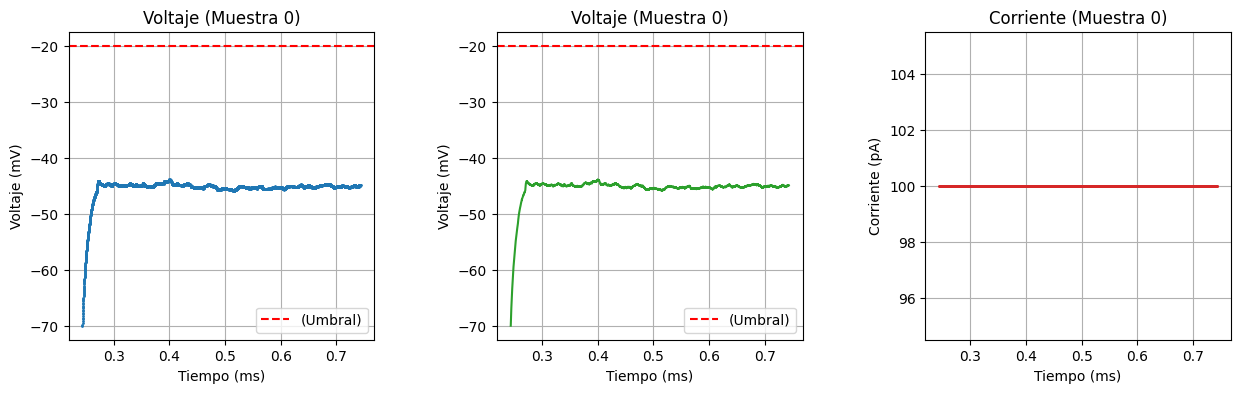

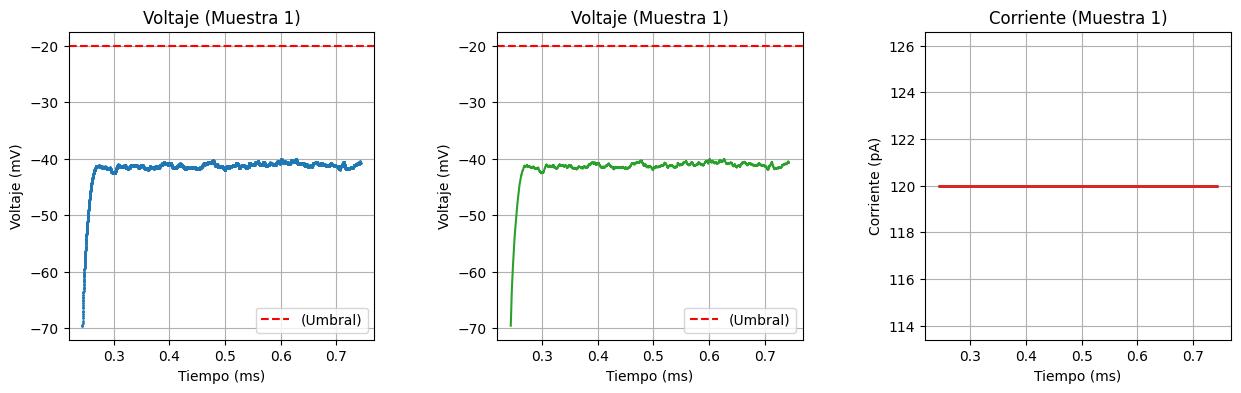

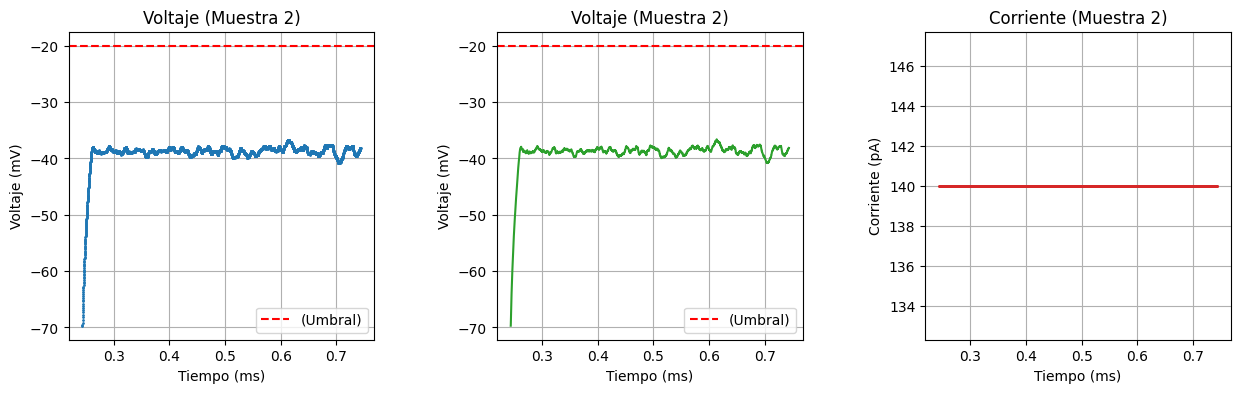

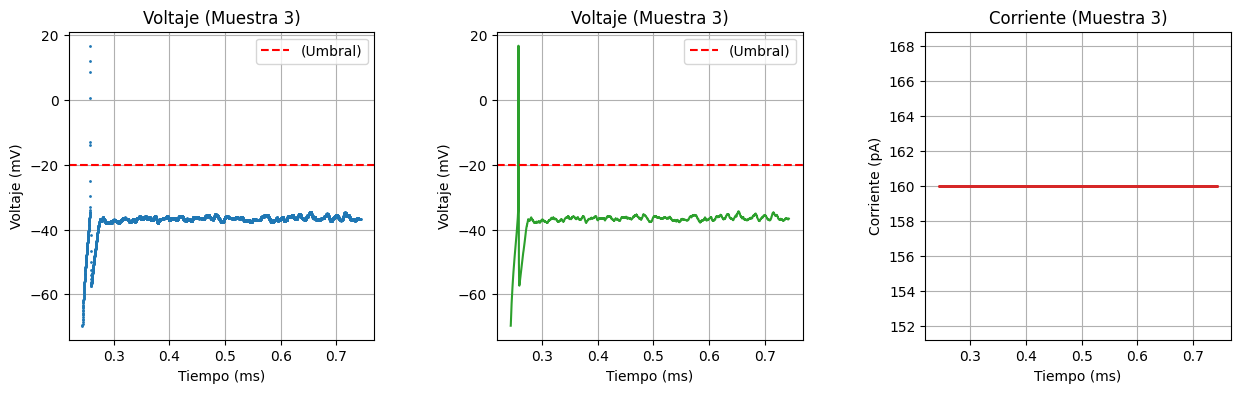

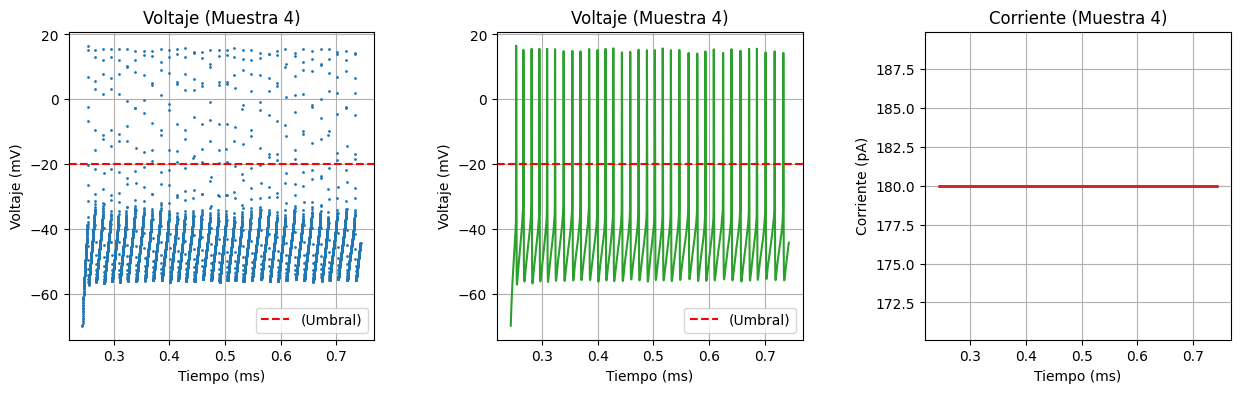

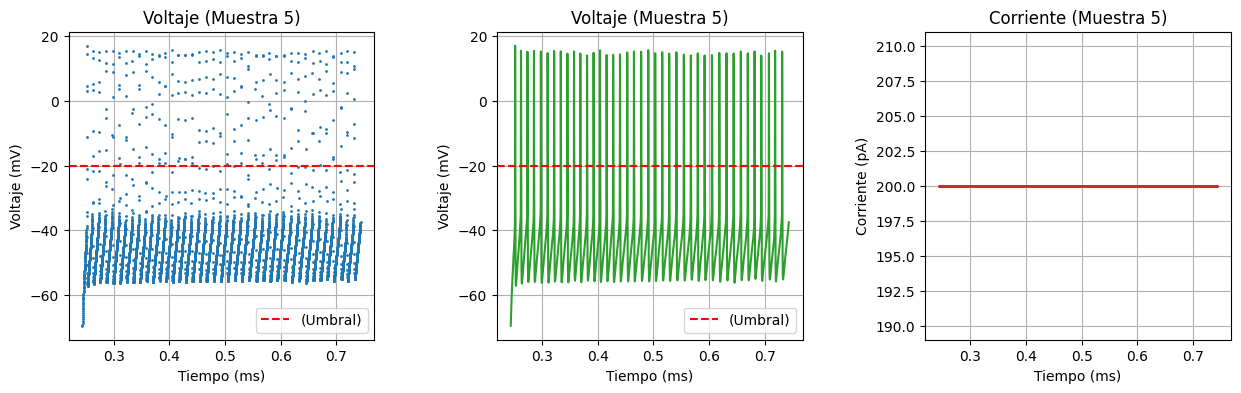

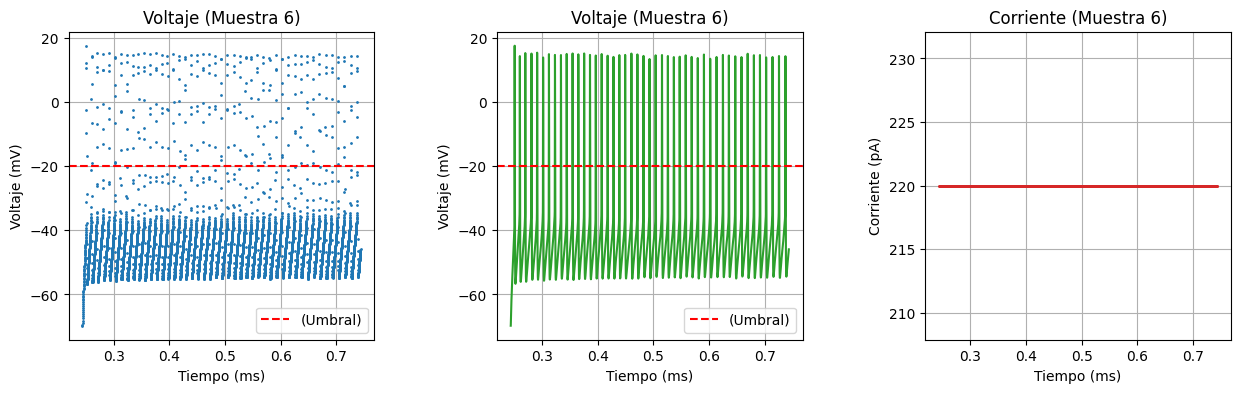

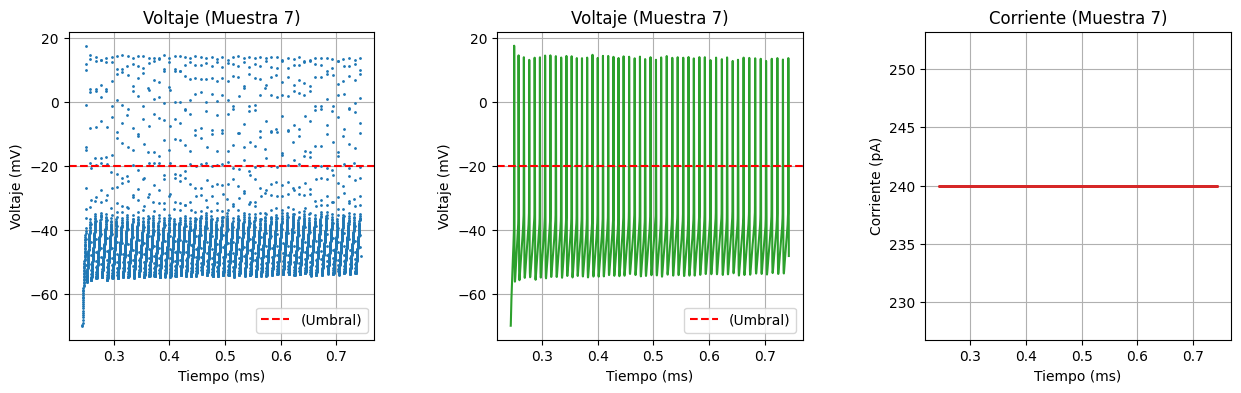

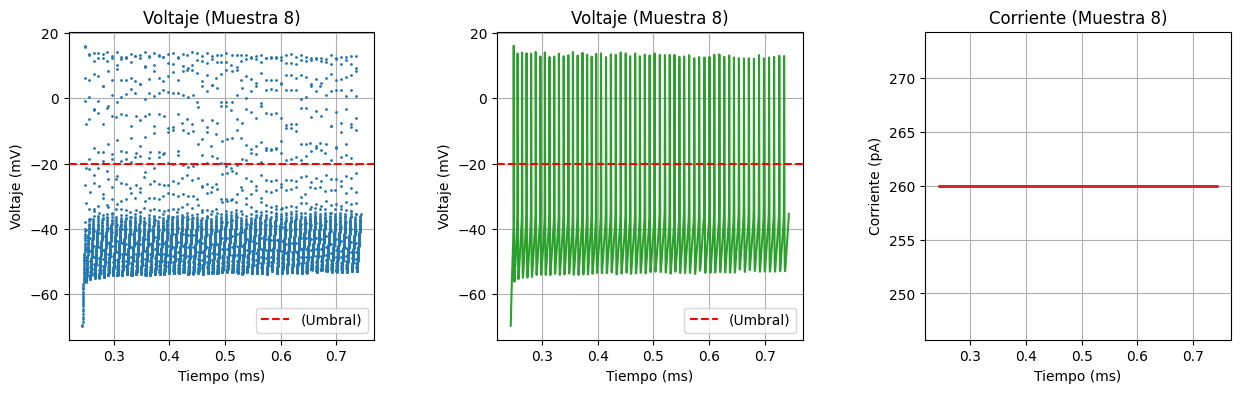

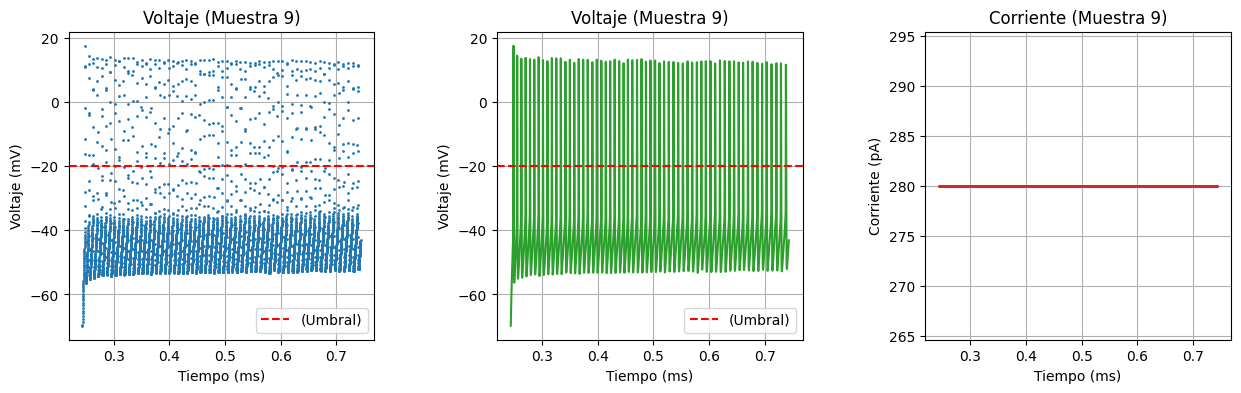

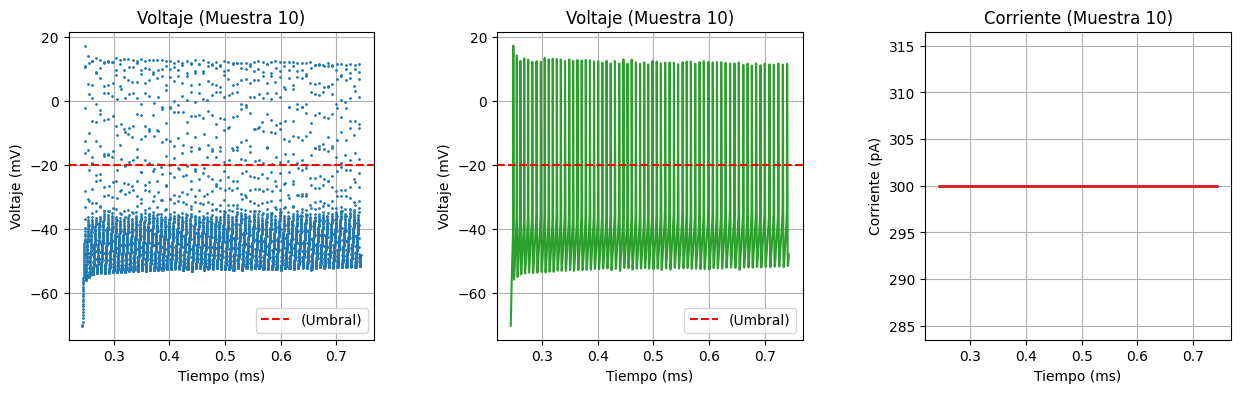

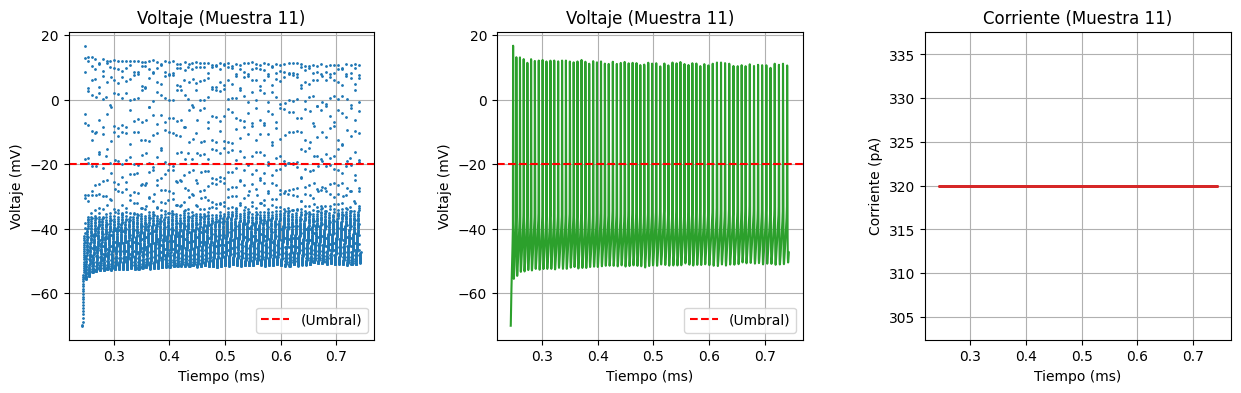

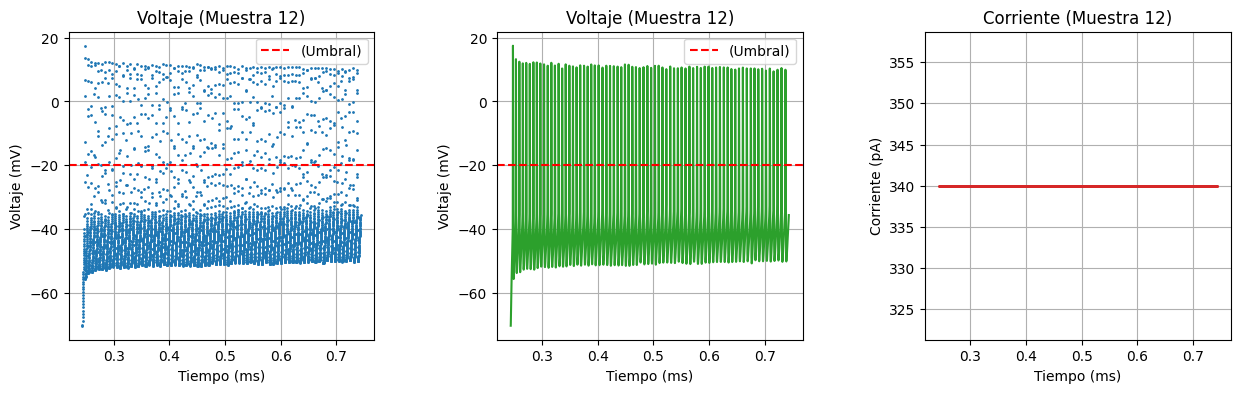

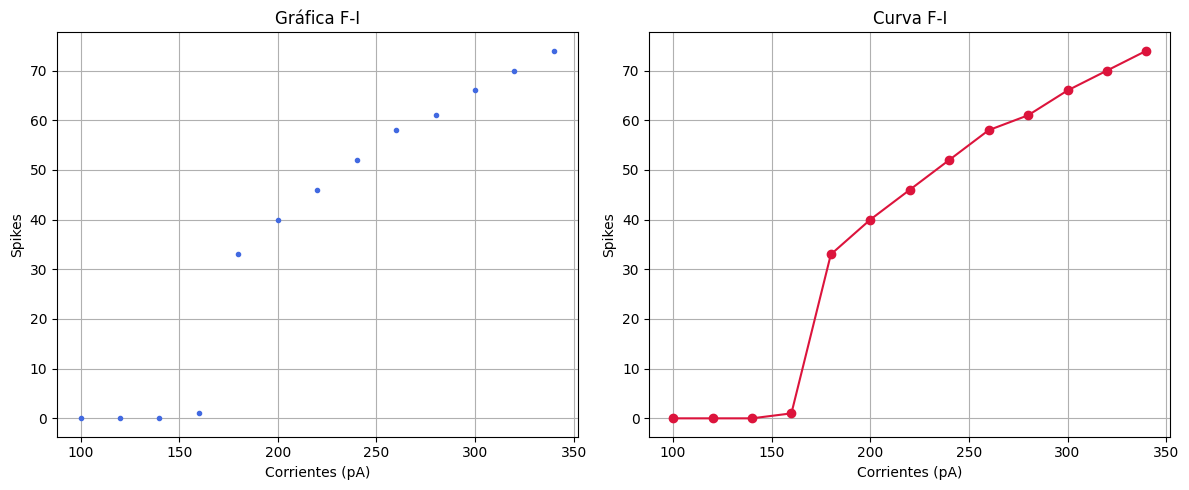

Neurona tipo 2 (inicio discreto en la curva F-I)


In [ ]:
from scipy.signal import find_peaks

corrientes_muestra = []
conteo_spikes = []
umbral_potential = -20

for i in range(13):
  abf.setSweep(i)

  tiempo = abf.sweepX
  voltaje = abf.sweepY
  corrientes = abf.sweepC

  if np.all(corrientes == 0):
        print(f'Muestra {i} no tiene corriente aplicada, se omite.')
        continue

  id_picos, _ = find_peaks(voltaje, height=umbral_potential)

  corrientes_muestra.append(max(corrientes))
  conteo_spikes.append(len(id_picos))

  # Detectar inicio y fin de la inyección de corriente
  indices_corriente = np.where(corrientes != 0)[0]
  start_idx = indices_corriente[0]
  end_idx = indices_corriente[-1] + 1

  tiempo_spikes = tiempo[start_idx:end_idx]
  voltaje_spikes = voltaje[start_idx:end_idx]
  corrientes_spikes = corrientes[start_idx:end_idx]

  # Crear una figura con 1 fila y 3 columnas de subplots
  fig, axs = plt.subplots(1, 3, figsize=(15, 4))
  plt.subplots_adjust(wspace=0.4)

  # --- Gráfico 1: Voltaje ---
  axs[0].plot(tiempo_spikes, voltaje_spikes, 'o', markersize=1, color='tab:blue')
  axs[0].axhline(y=umbral_potential, color='red', linestyle='--', label='(Umbral)')
  axs[0].set_title(f'Voltaje (Muestra {i})')
  axs[0].set_xlabel('Tiempo (ms)')
  axs[0].set_ylabel('Voltaje (mV)')
  axs[0].grid(True)
  axs[0].legend()

    # --- Gráfico 2: Voltaje linea ---
  axs[1].plot(tiempo_spikes, voltaje_spikes, '-', markersize=1, color='tab:green')
  axs[1].axhline(y=umbral_potential, color='red', linestyle='--', label='(Umbral)')
  axs[1].set_title(f'Voltaje (Muestra {i})')
  axs[1].set_xlabel('Tiempo (ms)')
  axs[1].set_ylabel('Voltaje (mV)')
  axs[1].grid(True)
  axs[1].legend()


  # --- Gráfico 3: Corriente ---
  axs[2].plot(tiempo_spikes, corrientes_spikes, 'x', markersize=1, color='tab:red')
  axs[2].set_title(f'Corriente (Muestra {i})')
  axs[2].set_xlabel('Tiempo (ms)')
  axs[2].set_ylabel('Corriente (pA)')
  axs[2].grid(True)

# --- Graficar spikes de los 13 experimentos---
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(corrientes_muestra, conteo_spikes, '.', color='royalblue')
axs[0].set_xlabel('Corrientes (pA)')
axs[0].set_ylabel('Spikes')
axs[0].set_title('Gráfica F-I')
axs[0].grid(True)

axs[1].plot(corrientes_muestra, conteo_spikes, '-o', color='crimson')
axs[1].set_xlabel('Corrientes (pA)')
axs[1].set_ylabel('Spikes')
axs[1].set_title('Curva F-I')
axs[1].grid(True)

plt.tight_layout()
plt.show()

# ---- Determinar tipo de neurona

indices_ordenados = np.argsort(corrientes_muestra)
corrientes_sorted = np.array(corrientes_muestra)[indices_ordenados]
spikes_sorted = np.array(conteo_spikes)[idx_sort]

indices_spikes = np.where(spikes_sorted > 0)[0]

if len(indices_spikes) == 0:
    resultado = "No se detectaron spikes, no se puede clasificar."
else:
    first_idx = indices_spikes[0]

    # Si hay al menos un punto después para comparar
    if first_idx + 1 < len(spikes_sorted):
        salto = spikes_sorted[first_idx + 1] - spikes_sorted[first_idx]
        umbral_spikes = 5

        if salto < umbral_spikes:
            resultado = "Neurona tipo 1 (inicio continuo en la curva F-I)"
        else:
            resultado = "Neurona tipo 2 (inicio discreto en la curva F-I)"
    else:
        resultado = "Datos insuficientes para determinar tipo neuronal."

print(resultado)